# Carga inicial de las librerias

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from surprise import KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

Carga y lectura de datos

In [2]:
def find_file_local(filename, search_path):
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            return os.path.join(root, filename)
    return None

# Nombre del archivo a buscar
file_name = 'Gift_Cards2.csv'

# Directorio actual donde se ejecuta el script
current_dir = os.getcwd()

# Buscar el archivo en el directorio actual
file_path = find_file_local(file_name, current_dir)

# Leer el archivo si se encuentra
if file_path:
    print(f"Archivo encontrado en: {file_path}")
    # Leer el archivo CSV con pandas y mostrar las primeras 10 filas
    df = pd.read_csv(file_path)
    print("Nombres de las columnas:", df.columns.tolist())
    print(df.head(10))

    # Filtrar el dataset para pruebas (opcional)
    min_interactions = 50
    user_counts = df['user_id'].value_counts()
    filtered_users = user_counts[user_counts >= min_interactions].index
    df = df[df['user_id'].isin(filtered_users)]

else:
    print(f"El archivo '{file_name}' no se encontró en la carpeta actual.")
    exit()

Archivo encontrado en: c:\Users\oscar\OneDrive\Escritorio\Universidad\Sistemas de recomendaciones\ProyectoRecomendacion\Nueva carpeta\Gift_Cards2.csv
Nombres de las columnas: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']
   rating                                              title  \
0     5.0                                         Great gift   
1     5.0                                   amazon gift card   
2     5.0                                       perfect gift   
3     5.0                                       Nice looking   
4     1.0                                 Not $10 Gift Cards   
5     5.0                                              Cute!   
6     5.0                                          Easy gift   
7     5.0                                         Great gift   
8     5.0                    Gifts for my two granddaughters   
9     5.0  Great for saying “thank you” to the mail perso...   

# Implementación algoritmo KNN vecimos más cercanos para filtrado colaborativo

In [4]:
# 1. Preparar el dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'title', 'rating']], reader)

In [5]:
# 2. Dividir el dataset en entrenamiento y prueba
trainset, testset = train_test_split(data, test_size=0.3)

# 3. Definir el algoritmo de k-NN con vecinos limitados y similitud de productos
sim_options = {
    'name': 'cosine',
    'user_based': False  # Cambia a similitud basada en productos
}
algo_knn = KNNBasic(k=30, sim_options=sim_options)  # valor optimo 20, pero igualmente entrenamos 30.

# 4. Entrenar el modelo
algo_knn.fit(trainset)

# 5. Hacer predicciones y evaluar
predictions = algo_knn.test(testset)
print("k-NN Coseno - RMSE:", accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3517
k-NN Coseno - RMSE: 0.35165059242938773


In [6]:
# 6. Calcular el MAE
y_true = [pred.r_ui for pred in predictions]  # Calificaciones reales
y_pred = [pred.est for pred in predictions]   # Calificaciones predichas
mae = mean_absolute_error(y_true, y_pred)
print("MAE:", mae)

MAE: 0.32786377708978326


Graficamos la dispersión del modelo

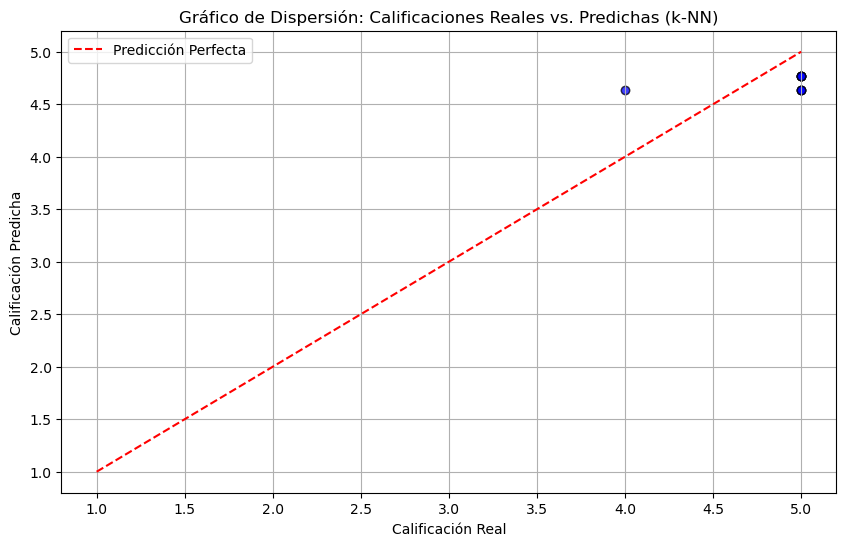

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='b', edgecolor='k')
plt.plot([1, 5], [1, 5], linestyle='--', color='r', label='Predicción Perfecta')
plt.xlabel('Calificación Real')
plt.ylabel('Calificación Predicha')
plt.title('Gráfico de Dispersión: Calificaciones Reales vs. Predichas (k-NN)')
plt.grid(True)
plt.legend()
plt.show()

# Gráfico variación Knn de MAE y RMSE

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


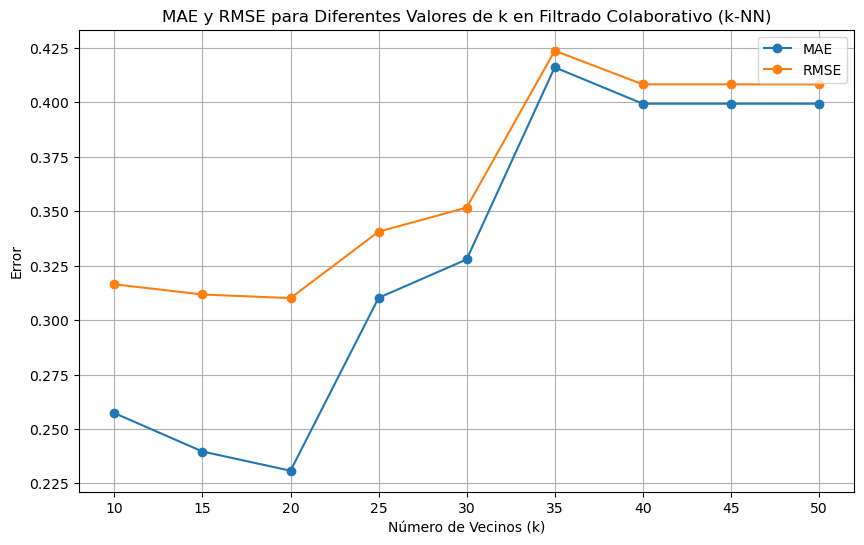

In [9]:
# Probar diferentes valores de k
k_values = [10, 15, 20, 25, 30, 35, 40, 45, 50]
mae_values = []
rmse_values = []

for k in k_values:
    # Definir el modelo k-NN
    sim_options = {'name': 'cosine', 'user_based': False}
    algo_knn = KNNBasic(k=k, sim_options=sim_options)
    
    # Entrenar el modelo y hacer predicciones
    algo_knn.fit(trainset)
    predictions = algo_knn.test(testset)
    
    # Calcular MAE y RMSE
    y_true = [pred.r_ui for pred in predictions]
    y_pred = [pred.est for pred in predictions]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = accuracy.rmse(predictions, verbose=False)
    
    mae_values.append(mae)
    rmse_values.append(rmse)

# Graficar MAE y RMSE en función de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_values, marker='o', label='MAE')
plt.plot(k_values, rmse_values, marker='o', label='RMSE')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Error')
plt.title('MAE y RMSE para Diferentes Valores de k en Filtrado Colaborativo (k-NN)')
plt.legend()
plt.grid(True)
plt.show()

# Implementación de filtrado por contenido - TF-IDF

In [10]:
# Crear una nueva columna combinando el título y la reseña del producto
df['product_features'] = df['title'] + " " + df['text']

# Rellenar valores nulos (si los hay) en las características de los productos
df['product_features'] = df['product_features'].fillna('')

# Filtrar el DataFrame para productos con características válidas
df_filtered = df[df['product_features'].str.strip() != ''].reset_index(drop=True)

# Aplicar TF-IDF a las características combinadas de los productos
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_filtered['product_features'])

# Mostrar el tamaño de la matriz TF-IDF
print("Matriz TF-IDF:", tfidf_matrix.shape)

Matriz TF-IDF: (55, 323)


In [11]:
# Función para recomendar productos similares
def get_content_recommendations(asin, df_filtered, cosine_sim, top_n=5):
    try:
        # Obtener el índice del producto correspondiente en el DataFrame filtrado
        idx = df_filtered[df_filtered['asin'] == asin].index[0]
        
        # Obtener los puntajes de similitud de ese producto con todos los demás
        sim_scores = list(enumerate(cosine_sim[idx]))
        
        # Ordenar productos por similitud
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        # Obtener los índices de los productos más similares
        sim_indices = [i[0] for i in sim_scores[1:top_n+1]]
        
        return df_filtered['title'].iloc[sim_indices]

    except IndexError:
        print("Error: Índice fuera de rango.")
        return []


# Calcular la similitud coseno entre todos los productos
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

asin_example = df_filtered['asin'].iloc[0]  # Usar el primer ASIN en el DataFrame filtrado
recommended_products = get_content_recommendations(asin_example, df_filtered, cosine_sim, top_n=5)
print(f"Productos similares a '{asin_example}':\n", recommended_products)

Productos similares a 'B076P58GC6':
 1     Great Easy To Use El Pollo Loco Gift Card!
11                        Easy to use gift card.
10              Easy to use Christmas gift card!
2                Great Gift Card from Five Guys!
3           Easy to Use Jersey Mike's Gift Card!
Name: title, dtype: object


In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def hybrid_recommendation(user_id, algo, df, alpha=0.5, top_n=10):
    """
    Esta funcion se utiliza para generar recomendaciones híbridas combinando filtrado colaborativo y filtrado por contenido.

    :param user_id: ID del usuario
    :param algo: Modelo de filtrado colaborativo (surprise)
    :param df: DataFrame con los datos de los productos
    :param alpha: Peso para el filtrado colaborativo (0 < alpha < 1)
    :param top_n: Número de recomendaciones a generar
    :return: Lista de tuplas con las recomendaciones híbridas (nombre del producto, puntuación híbrida)
    """
    # Filtrado colaborativo: obtener predicciones para el usuario
    user_items = df[df['user_id'] == user_id]['asin'].unique()
    item_recs = []

    for item in user_items:
        est_rating = algo.predict(user_id, item).est
        item_recs.append((item, est_rating))

    # Normalizar las calificaciones del contenido
    item_ratings = df[df['asin'].isin(user_items)].groupby('asin')['rating'].mean().reset_index()
    scaler = MinMaxScaler(feature_range=(0, 1))
    item_ratings['norm_rating'] = scaler.fit_transform(item_ratings[['rating']])

    # Filtrado de contenido: usar las calificaciones normalizadas
    content_recs = [(row['asin'], row['norm_rating']) for _, row in item_ratings.iterrows()]

    # Calcular la puntuación híbrida combinando ambas recomendaciones
    hybrid_scores = []
    for (item, cf_score), (_, content_score) in zip(item_recs, content_recs):
        hybrid_score = alpha * cf_score + (1 - alpha) * content_score
        hybrid_scores.append((item, hybrid_score))

    # Ordenar las recomendaciones híbridas por puntuación y seleccionar las mejores
    hybrid_scores.sort(key=lambda x: x[1], reverse=True)
    return hybrid_scores[:top_n]

In [49]:

def plot_hybrid_recommendations(hybrid_recs):
    """
    :param hybrid_recs: Lista de tuplas con el nombre del producto y la puntuación híbrida.
    """
    if not hybrid_recs or not all(isinstance(score, (int, float)) for _, score in hybrid_recs):
        print("Advertencia: No hay datos válidos para graficar.")
        return

    items = [item for item, _ in hybrid_recs]
    scores = [score for _, score in hybrid_recs]

    # Crear el gráfico de barras
    plt.figure(figsize=(12, 8))
    plt.barh(items, scores, color='skyblue')
    plt.xlabel('Puntuación Híbrida', fontsize=14)
    plt.ylabel('Producto', fontsize=14)
    plt.title('Recomendaciones Híbridas para el Usuario', fontsize=16)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()


Recomendaciones para el usuario: AF4OCZTPFHXZKUTAGP6CAOCMWPAA
Recomendaciones Híbridas: [('B076P58GC6', 2.8157894736842106), ('B00BXLTOJ8', 2.8157894736842106), ('B077CYG3TH', 2.8157894736842106), ('B07WT7CKKW', 2.8157894736842106), ('B07RN9P435', 2.8157894736842106)]


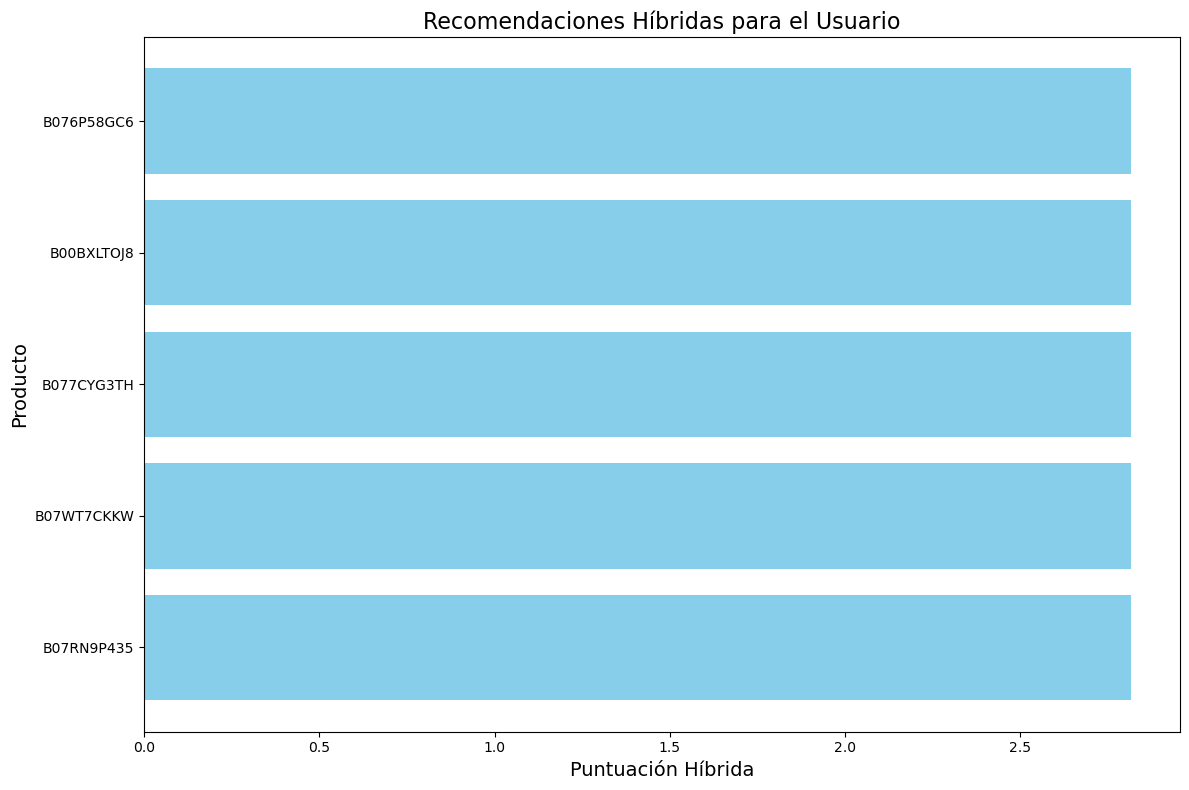

In [50]:
# Uso del modelo híbrido para ejecutar una prueba
import random

num_usuarios = 1
usuarios_unicos = list(df['user_id'].unique())

if num_usuarios > len(usuarios_unicos):
    print("El número de usuarios únicos es menor al número solicitado.")
else:
    # Seleccionar usuarios únicos de forma aleatoria
    usuarios_aleatorios = random.sample(usuarios_unicos, num_usuarios)

    for user_id in usuarios_aleatorios:
        print(f"\nRecomendaciones para el usuario: {user_id}")

        # Obtener recomendaciones híbridas
        hybrid_recs = hybrid_recommendation(user_id, algo_knn, df, alpha=0.5, top_n=5)

        # Mostrar las recomendaciones híbridas
        print("Recomendaciones Híbridas:", hybrid_recs)

        # Graficar las recomendaciones híbridas
        plot_hybrid_recommendations(hybrid_recs)

In [57]:
print(f"Media de rating: {df['rating'].mean():.2f}", 
      f"Desviación estándar de 'rating': {df['rating'].std():.2f}")

Media de rating: 4.71 Desviación estándar de 'rating': 0.90


# Aplicación de metodos de validación cruzada

importaciones

In [68]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [69]:
# 1. Preprocesamiento de texto con TF-IDF
def aplicar_tfidf(df, columna_texto):
    # Inicializar el vectorizador TF-IDF
    tfidf = TfidfVectorizer(stop_words='english')

    # Aplicar TF-IDF a la columna de texto
    tfidf_matrix = tfidf.fit_transform(df[columna_texto].fillna(''))

    print(f"Matriz TF-IDF: {tfidf_matrix.shape}")
    return tfidf_matrix

# 2. Aplicar TF-IDF a los títulos de los artículos
tfidf_matrix = aplicar_tfidf(df, 'title')

Matriz TF-IDF: (55, 93)


In [70]:
# 3. Crear un modelo de recomendación basado en contenido utilizando TF-IDF y similitud coseno

"""
Esta función genera recomendaciones basadas en el contenido utilizando TF-IDF y similitud de coseno.
:param user_id: ID del usuario para el que se generarán las recomendaciones
:param df: DataFrame con los datos de los productos
:param tfidf_matrix: Matriz TF-IDF de los títulos de los productos
:param top_n: Número de recomendaciones a generar
"""

def content_based_recommendation_tfidf(user_id, df, tfidf_matrix, top_n=5):

    # Seleccionar un artículo aleatorio comprado por el usuario
    usuario_articulos = df[df['user_id'] == user_id]['title'].values
    if len(usuario_articulos) == 0:
        return []

    # Obtener el índice del primer artículo del usuario
    idx_usuario = df[df['title'] == usuario_articulos[0]].index[0]

    # Calcular la similitud coseno con TF-IDF
    sim_scores = list(enumerate(cosine_similarity(tfidf_matrix[idx_usuario], tfidf_matrix)[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtener los índices de los productos más similares
    sim_indices = [i[0] for i in sim_scores[1:top_n+1]]

    return df['title'].iloc[sim_indices].tolist()

In [71]:
# 4. Realizar validación cruzada

"""
Esta función realiza validación cruzada para evaluar el modelo de filtrado basado en contenido utilizando TF-IDF.
:param tfidf_matrix: Matriz TF-IDF de los títulos de los productos
:param num_folds: Número de folds para la validación cruzada
"""

def validacion_cruzada_tfidf(df, tfidf_matrix, num_folds=5):

    # Crear el modelo de clasificación para validación
    X = tfidf_matrix
    y = df['rating'] >= df['rating'].mean()  # Etiquetas: 1 si la calificación es >= media, 0 si es menor

    # Configurar la validación cruzada
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Utilizar un clasificador simple para la validación
    modelo = LogisticRegression(max_iter=1000)

    # Definir los scorers para las métricas
    scorers = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }
    
    # Calcular las métricas para cada fold
    precision_scores = cross_val_score(modelo, X, y, cv=kf, scoring=scorers['precision'])
    recall_scores = cross_val_score(modelo, X, y, cv=kf, scoring=scorers['recall'])
    f1_scores = cross_val_score(modelo, X, y, cv=kf, scoring=scorers['f1'])

    # Calcular las métricas acumuladas en el tiempo
    precision_acumulada = np.cumsum(precision_scores) / np.arange(1, num_folds + 1)
    recall_acumulada = np.cumsum(recall_scores) / np.arange(1, num_folds + 1)
    f1_acumulada = np.cumsum(f1_scores) / np.arange(1, num_folds + 1)

    # Graficar las métricas acumuladas en el tiempo
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, num_folds + 1), precision_acumulada, marker='o', linestyle='-', label='Precisión', color='b')
    plt.plot(range(1, num_folds + 1), recall_acumulada, marker='o', linestyle='-', label='Recall', color='g')
    plt.plot(range(1, num_folds + 1), f1_acumulada, marker='o', linestyle='-', label='F1-score', color='r')

    plt.title('Precisión, Recall y F1-score Acumulados en la Validación Cruzada', fontsize=16)
    plt.xlabel('Fold', fontsize=14)
    plt.ylabel('Métricas Acumuladas', fontsize=14)
    plt.ylim([0, 1])  # Ajustar el rango del eje Y para que vaya de 0 a 1
    plt.xticks(range(1, num_folds + 1))
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Mostrar las métricas promedio
    print(f"Precisión promedio en validación cruzada: {precision_scores.mean():.2f}")
    print(f"Recall promedio en validación cruzada: {recall_scores.mean():.2f}")
    print(f"F1-score promedio en validación cruzada: {f1_scores.mean():.2f}")
    return precision_scores.mean(), recall_scores.mean(), f1_scores.mean()


# Ejecutar la validación cruzada

Matriz TF-IDF: (55, 93)


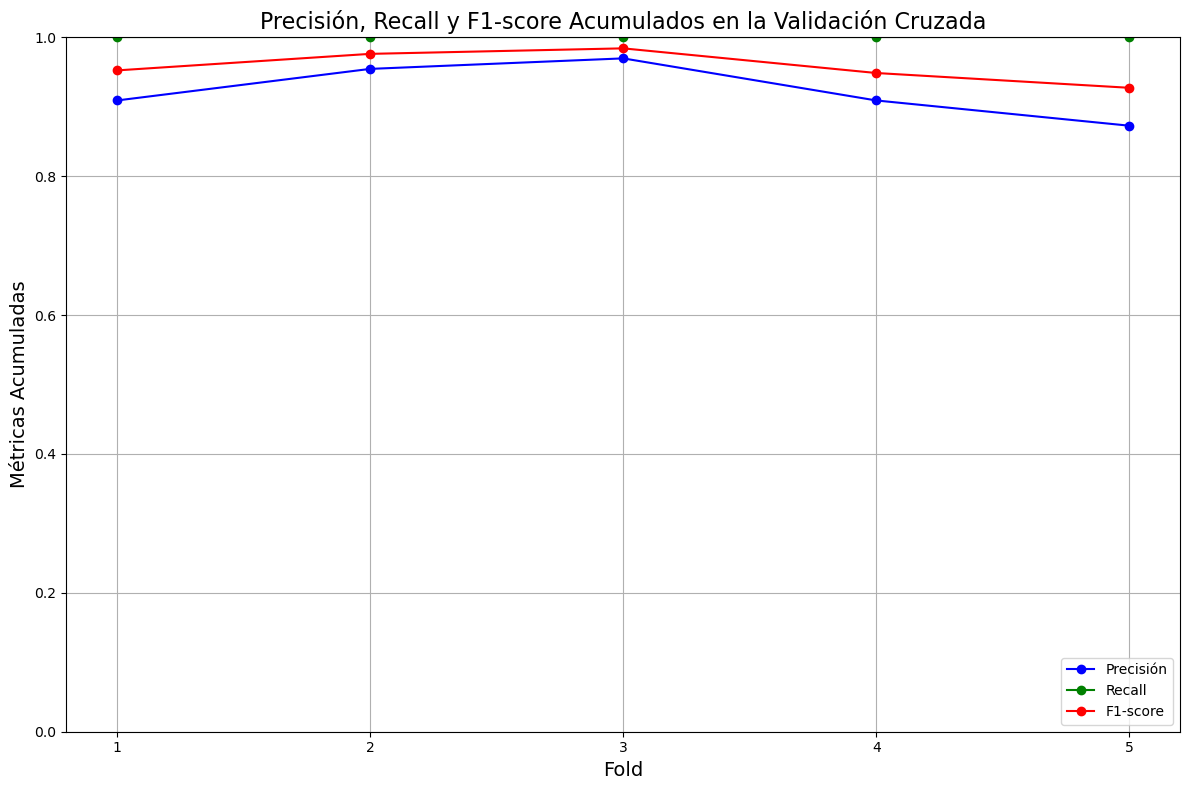

Precisión promedio en validación cruzada: 0.87
Recall promedio en validación cruzada: 1.00
F1-score promedio en validación cruzada: 0.93


(0.8727272727272728, 1.0, 0.9273182957393484)

In [72]:
# 1. Aplicar TF-IDF a los títulos de los productos
tfidf_matrix = aplicar_tfidf(df, 'title')

# 2. Ejecutar la validación cruzada con gráfica acumulada
validacion_cruzada_tfidf(df, tfidf_matrix, num_folds=5)

# Prueba KNN y SVD

In [10]:
# 1. Preprocesamiento de texto con TF-IDF
def aplicar_tfidf(df, columna_texto):
    if columna_texto not in df.columns:
        raise ValueError(f"La columna '{columna_texto}' no se encuentra en el DataFrame.")
    
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df[columna_texto].fillna(''))
    return tfidf_matrix, tfidf

# 2. Reducción de dimensionalidad con SVD
def aplicar_svd(tfidf_matrix, n_components=55):
    if tfidf_matrix.shape[1] < n_components:
        raise ValueError(f"El número de componentes ({n_components}) excede la dimensionalidad de la matriz TF-IDF ({tfidf_matrix.shape[1]}).")
    
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    tfidf_reducida = svd.fit_transform(tfidf_matrix)
    print(f"Dimensiones reducidas: {tfidf_reducida.shape}")
    return tfidf_reducida

# 3. Recomendación con k-NN sobre las características reducidas
def knn_recommendation_svd(user_id, df, tfidf_reducida, top_n=5):
    knn = NearestNeighbors(n_neighbors=top_n + 1, metric='cosine')
    knn.fit(tfidf_reducida)

    # Seleccionar un artículo aleatorio comprado por el usuario
    usuario_articulos = df[df['user_id'] == user_id]['title'].values
    if len(usuario_articulos) == 0:
        print(f"El usuario '{user_id}' no tiene artículos asociados.")
        return []

    # Obtener el índice del primer artículo del usuario en la matriz reducida
    idx_usuario = df[df['title'] == usuario_articulos[0]].index[0] % len(tfidf_reducida)

    # Encontrar los índices de los productos más similares
    _, indices = knn.kneighbors([tfidf_reducida[idx_usuario]])

    # Concatenar ASIN y TITLE para mostrar en las recomendaciones
    recomendaciones = df.iloc[indices[0][1:]][['asin', 'title']].copy()
    recomendaciones['asin_title'] = recomendaciones['asin'] + " - " + recomendaciones['title']

    return recomendaciones['asin_title'].tolist()

# 4.1 Aplicar TF-IDF
try:
    tfidf_matrix, tfidf = aplicar_tfidf(df, 'title')
except ValueError as e:
    print(e)

# 4.2 Reducir la dimensionalidad con SVD
try:
    tfidf_reducida = aplicar_svd(tfidf_matrix, n_components=55)
except ValueError as e:
    print(e)

# 4.3 Obtener recomendaciones para un usuario específico con k-NN
user_id_example = df['user_id'].iloc[0]
recomendaciones_svd_knn = knn_recommendation_svd(user_id_example, df, tfidf_reducida, top_n=5)

# 4.4 Mostrar las recomendaciones
print(f"Recomendaciones con SVD + k-NN para el usuario '{user_id_example}':\n", recomendaciones_svd_knn)

Dimensiones reducidas: (55, 55)
Recomendaciones con SVD + k-NN para el usuario 'AF4OCZTPFHXZKUTAGP6CAOCMWPAA':
 ["B00CHQ7LSY - It's a perfect gift for your friends or family", 'B07SSFSFJD - Great gift card for friends in holiday season', 'B07WRT1LZM - Easy to use gift card.', 'B00AS527QW - Great movie gift card', 'B077CYG3TH - Great Gift Card from Five Guys!']


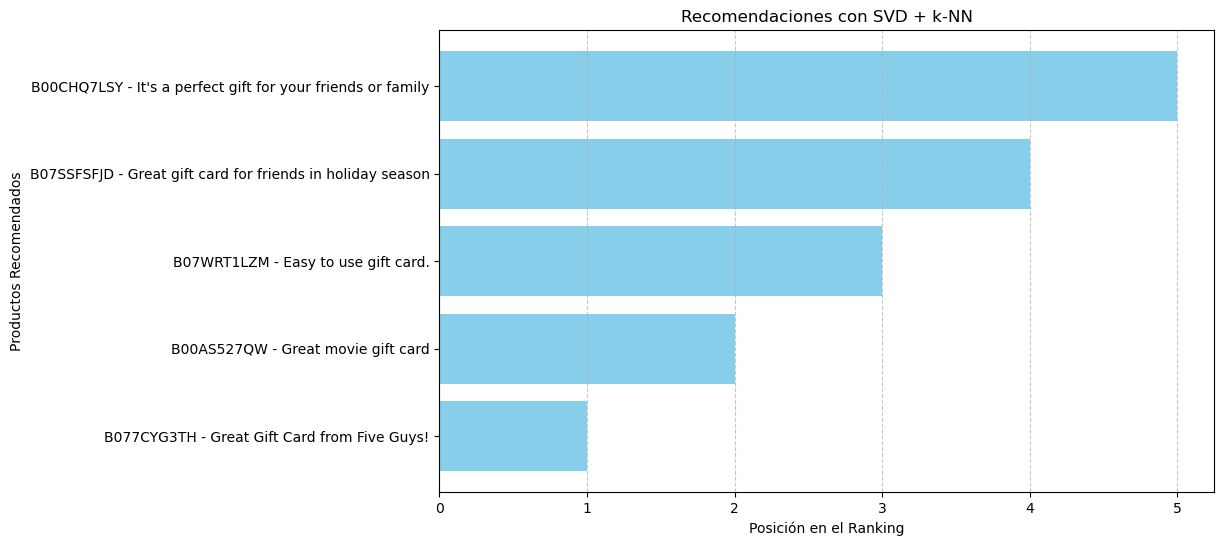

In [11]:
# Función para graficar las recomendaciones SVD + k-NN
def plot_svd_knn_recommendations(recommendations):

    if not recommendations:
        print("No hay recomendaciones para graficar.")
        return
    
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.barh(recommendations, range(len(recommendations), 0, -1), color='skyblue')
    plt.xlabel('Posición en el Ranking')
    plt.ylabel('Productos Recomendados')
    plt.title('Recomendaciones con SVD + k-NN')
    plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar el más relevante arriba
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()


plot_svd_knn_recommendations(recomendaciones_svd_knn)